# Model 1 - Horizontal stratigraphic

This is the most simpel model of horizontally stacked layers. We start by importing the necessary dependencies:

In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
#sys.path.append("../..")
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu"

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

Creating the model by importing the input data and displaying it:

In [2]:
geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=[50,50,50], 
                        path_o = os.pardir+"/data/input_data/jan_models/model1_orientations.csv",
                        path_i = os.pardir+"/data/input_data/jan_models/model1_surface_points.csv") 

Active grids: ['regular']


Setting and ordering the units and series:

In [3]:
gp.map_series_to_surfaces(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')})

,surface,series,order_surfaces,isBasement,color,id
0,rock2,Strat_Series,1,False,#015482,1
1,rock1,Strat_Series,2,False,#9f0052,2
2,basement,Basement_Series,1,True,#ffbe00,3


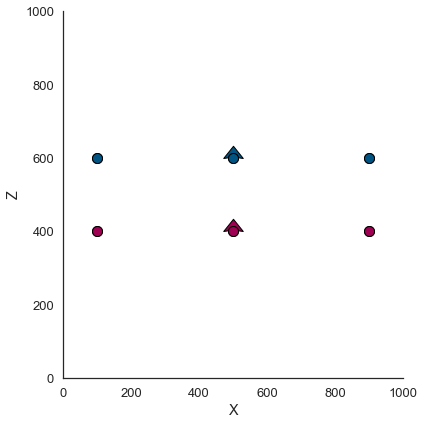

In [4]:
%matplotlib inline
gp.plot.plot_data(geo_data, direction='y')

Calculating the model:

In [5]:
interp_data = gp.set_interpolation_data(geo_data, compile_theano=True,
                                        theano_optimizer='fast_run')

Compiling theano function...


/Users/andrew/anaconda3/envs/gempy3/lib/python3.7/site-packages/theano/gof/cc.py:968: UserWarning: Your g++ compiler fails to compile OpenMP code. We know this happen with some version of the EPD mingw compiler and LLVM compiler on Mac OS X. We disable openmp everywhere in Theano. To remove this warning set the theano flags `openmp` to False.
  ret += x.c_compile_args()


Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!


In [6]:
combined_grid = gp.core.data.Grid()
combined_regular_grid = combined_grid.set_regular_grid(extent=[0, 1000, 0, 1000, 0, 1000], resolution=[100,100,50])
combined_solution = gp.core.model.Solution(grid=combined_grid, surfaces=geo_data.surfaces, series=geo_data.series)

In [7]:
def define_subgrids(grid, n):
    """
    Given a gempy grid, define n by n sub grids that split the grid on the x and y extent
    """
    grid_resolution = grid.regular_grid.resolution
    grid_extent = grid.regular_grid.extent
    minx, miny, minz = grid_extent[0::2]
    maxx, maxy, maxz = grid_extent[1::2]
    newxres = grid_resolution[0] // n
    newyres = grid_resolution[1] // n
    x_step = (maxx-minx) // n
    y_step = (maxy-miny) // n
    results = []
    for x in np.arange(minx, maxx, x_step):
        for y in np.arange(miny, maxy, y_step):
            results.append(([x, x+x_step, y, y+y_step, minz, maxz], [newxres, newyres, grid_resolution[-1]]))
    return results
    

In [8]:
grids = define_subgrids(combined_grid, 2)

In [9]:
grids

[([0.0, 500.0, 0.0, 500.0, 0.0, 1000.0], [50, 50, 50]),
 ([0.0, 500.0, 500.0, 1000.0, 0.0, 1000.0], [50, 50, 50]),
 ([500.0, 1000.0, 0.0, 500.0, 0.0, 1000.0], [50, 50, 50]),
 ([500.0, 1000.0, 500.0, 1000.0, 0.0, 1000.0], [50, 50, 50])]

In [10]:
solutions = []
#grids = [[0,1000,0,500,0,1000],[0,1000,500,1000,0,1000]]
gp.compute_model(geo_data) # Todo remove?
for extent, res in grids:
    grid = gp.core.data.Grid()
    grid.set_regular_grid(extent=extent, resolution=res)
    geo_data.set_regular_grid(extent, res)
    sol = gp.compute_model(geo_data, output='geology', compute_mesh=False, set_solutions=False, 
                           reset_scalar=False, reset_block=False, reset_weights=False)
    solutions.append((extent,grid,sol))
    

/Users/andrew/PycharmProjects/gempy/gempy/core/solution.py:260: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


Active grids: ['regular']
Active grids: ['regular']
Active grids: ['regular']
Active grids: ['regular']


In [80]:
def update_xarray_grid(target, grid, values):
    v = grid.regular_grid.values.T
    c = {'x': np.unique(v[0]), 
         'y': np.unique(v[1]), 
         'z': np.unique(v[2])}
    target.loc[c] = values.reshape(grid.regular_grid.resolution)

def do_combine_grids(target_grid, solutions):
    extent = target_grid.regular_grid.extent
    res = target_grid.regular_grid.resolution
    v = target_grid.regular_grid.values.T
    c = {'x': np.unique(v[0]), 'y': np.unique(v[1]), 'z': np.unique(v[2])}
    v0_target = xr.DataArray(np.zeros(res), coords=c, dims=['x','y','z'])
    v1_target = xr.DataArray(np.zeros(res), coords=c, dims=['x','y','z'])
    v3_target = xr.DataArray(np.zeros(res), coords=c, dims=['x','y','z'])
    v5_target = xr.DataArray(np.zeros(res), coords=c, dims=['x','y','z'])
    # make big loop
    vals = [[], [], [], [], [], []]
    val_tails = [[], [], [], []]
    for _, g, s in solutions:
        vv = g.regular_grid.values.T
        l0, l1 = g.get_grid_args('regular')
        x_l = g.length[-1]
        # extract values we need
        v0 = np.asarray(s[0][0, l0: l1])
        v1 = np.asarray(s[1][0, 0, l0: l1])
        v3 = np.asarray(s[3][0, l0: l1])
        v5 = np.asarray(s[5][0, l0: l1])
        # assign the xarray using the coordinates of the grid
        update_xarray_grid(v0_target, g, v0)
        update_xarray_grid(v1_target, g, v1)
        update_xarray_grid(v3_target, g, v3)
        update_xarray_grid(v5_target, g, v5)
        # update vals accumulation
        vals[2].append(s[2])
        vals[4].append(s[4])
        # update tails for lack of a better term
        val_tails[0].append(s[0][:, x_l:].ravel())
        val_tails[1].append(s[1][:,:, x_l:].ravel())
        val_tails[2].append(s[3][:, x_l:].ravel())
        val_tails[3].append(s[5][:, x_l:].ravel())
    # combine tails
    for i, tail in enumerate(val_tails):
        dtype = tail[0].dtype
        val_tails[i] = np.mean(tail,axis=0)
        if dtype == np.bool:
            val_tails[i] = val_tails[i].astype(bool)
    
    vals[0] = np.concatenate((v0_target.values.ravel(), val_tails[0]))[np.newaxis,:]
    vals[1] = np.concatenate((v1_target.values.ravel(), val_tails[1]))[np.newaxis, np.newaxis,:]
    vals[2] = np.mean(vals[2],axis=0)
    vals[3] = np.concatenate((v3_target.values.ravel(), val_tails[2]))[np.newaxis,:]
    vals[4] = np.mean(vals[4],axis=0)
    vals[5] = np.concatenate((v5_target.values.ravel().astype(bool), val_tails[3]))[np.newaxis,:]
    return vals
    
def set_gridded_solutions_to_regular_grid(model, combined_solution, target_grid, solutions):
    vals = do_combine_grids(target_grid, solutions)
    combined_solution.set_solution_to_regular_grid(vals, compute_mesh=True)
    model.solutions = combined_solution
    model.grid = target_grid
    return model
    

In [84]:
x = set_gridded_solutions_to_regular_grid(geo_data, combined_solution, combined_grid, solutions);

In [92]:
geo_data.solutions.lith_block.shape

(500000,)

In [185]:
def combine_sols(combo_grid, solutions):
    target_l0, target_l1 = combo_grid.get_grid_args('regular')
    target_xi = combo_grid.length[-1]
    vals = [[], [], None, [], None, []]
    for i, (_, g, s) in enumerate(solutions):
        l0, l1 = g.get_grid_args('regular')
        x_l = g.length[-1]
        # extract values we need
        v0 = np.asarray(s[0][0, l0: l1])
        v1 = np.asarray(s[1][0, 0, l0: l1])
        v3 = np.asarray(s[3][0, l0: l1])
        v5 = np.asarray(s[5][0, l0: l1])
        # may need to reshape, strack then ravel
        #print(type(vals[0]), type(v0))
        #print(vals[0].shape, v0.shape)
        vals[0] = np.concatenate((vals[0], v0)) 
        vals[1] = np.concatenate((vals[1], v1)) 
        vals[3] = np.concatenate((vals[3], v3)).ravel() 
        vals[5] = np.concatenate((vals[5], v5)).ravel()
        # for the things we do at the end for the surface values
        if i+1 == len(solutions):
            vals[0] = np.concatenate((vals[0], s[0][:, x_l:].ravel()))
            vals[1] = np.concatenate((vals[1], s[1][:,:, x_l:].ravel())) 
            vals[2] = s[2]
            vals[3] = np.concatenate((vals[3], s[3][:, x_l:].ravel())) 
            vals[4] = s[4]
            vals[5] = np.concatenate((vals[5], s[5][:, x_l:].ravel()))
    vals[0] = vals[0].reshape((1, vals[0].shape[0]))
    vals[1] = vals[1].reshape((1, 1, vals[1].shape[0]))
    vals[3] = vals[3].reshape((1, vals[3].shape[0]))
    vals[5] = vals[5].reshape((1, vals[5].shape[0]))
    return vals
          

In [186]:
vals = combine_sols(combined_grid, solutions)

In [187]:
combined_solution.set_solution_to_regular_grid(vals, compute_mesh=True)


Lithology ids 
  [3. 3. 3. ... 1. 1. 1.] 

In [188]:
geo_data.solutions = combined_solution
geo_data.grid = combined_grid

Displaying the result in x and y direction:

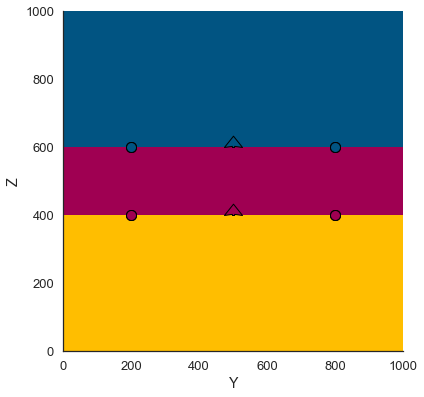

In [189]:
%matplotlib inline
gp.plot.plot_section(geo_data, cell_number=25,
                         direction='x', show_all_data=True)

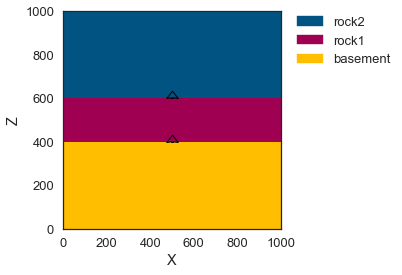

In [190]:
%matplotlib inline
gp.plot.plot_section(geo_data, cell_number=25,
                    direction='y', show_data=True)